In [1]:
#Exploration of New product - September 2021
#Section with PCs and with Levels
import datetime as dt 
import glob
import netCDF4 as nc
import numpy as np
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import cmocean
import gsw

import yaml

import sklearn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import xarray as xr
import numpy as np
import pandas as pd



import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config["data_dir"] = './cartopy_shapefiles'

os.getcwd()
pathMon = '/home/datawork-lops-bluecloud/osnet/grilled_Nordic_Sea/'
pathfig = '/home/datawork-lops-bluecloud/osnet/grilled_Nordic_Sea/figures/'

In [2]:
with open(r'configuration.yaml') as file:
    configuration = yaml.load(file, Loader=yaml.FullLoader)

    print("File version: ", configuration["version"])

File version:  0.1


In [3]:
%%time
#Plot section with longitude fixed
#Test on the product for 2016 January 01
t = '1993-01-01'
yy = t[0:4]
mm = t[5:7]
dd = t[8:10]

ds = xr.open_dataset(pathMon + "produit_199301.nc")
ds.load()

CPU times: user 24 ms, sys: 92 ms, total: 116 ms
Wall time: 385 ms


<xarray.Dataset>
Dimensions:             (time: 31, lat: 32, lon: 100, DEPTH: 51)
Coordinates:
    mask                (time, lat, lon) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
  * DEPTH               (DEPTH) int64 0 1 2 3 4 5 6 ... 628 697 773 857 950 1000
  * time                (time) datetime64[ns] 1993-01-01 ... 1993-01-31
  * lat                 (lat) float64 69.12 69.38 69.62 ... 76.38 76.62 76.88
  * lon                 (lon) float64 -19.88 -19.62 -19.38 ... 4.375 4.625 4.875
Data variables: (12/17)
    SLA                 (time, lat, lon) float32 -0.031 -0.0286 ... -0.0605
    UGOS                (time, lat, lon) float32 -0.0263 -0.0258 ... -0.0129
    VGOS                (time, lat, lon) float32 -0.0532 -0.0446 ... 0.072
    UGOSA               (time, lat, lon) float32 -0.0074 -0.0102 ... -0.0056
    VGOSA               (time, lat, lon) float32 0.0165 0.0184 ... 0.0491 0.0496
    SLA_err             (time, lat, lon) float32 0.0129 0.0127 ... 0.0176 0.0167
    ...                  ...
    PSAL_predicted      (DEPTH, time, lat, lon) float32 34.76 34.79 ... 34.9
    TEMP_predicted      (DEPTH, time, lat, lon) float32 0.04745 ... -0.5949
    PSAL_predicted_std  (DEPTH, time, lat, lon) float32 0.03623 ... 0.00411
    TEMP_predicted_std  (DEPTH, time, lat, lon) float32 0.1315 ... 0.09781
    MLD_mask            (DEPTH, time, lat, lon) float32 2.409e-07 ... 0.8051
    SIG_predicted       (DEPTH, time, lat, lon) float64 27.91 27.93 ... 28.06

In [4]:
#Map of TS
proj=ccrs.NorthPolarStereo()
land_feature = cfeature.NaturalEarthFeature(
category='physical', name='land', scale='50m', facecolor=[0.9375, 0.9375, 0.859375])
extent = np.array([12, -20, 65, 80])
subplot_kw = {'projection': proj, 'extent': extent}

#To get the bathymetry
ds_bat = xr.open_dataset(configuration['BATHYMETRIE_output_path'] + configuration['BATHYMETRIE_FILE_NAME'])

ds_bat = ds_bat.where((ds_bat.LONGITUDE>=configuration['longitude1']) & (ds_bat.LONGITUDE<=configuration['longitude2']) & (ds_bat.LATITUDE>=configuration['latitude2']) & 
              (ds_bat.LATITUDE<=configuration['latitude1'])==False,-1500)

kw = {'levels':[-1000], 'colors':['black'],'linewidths':[1],'linestyles':['solid']}

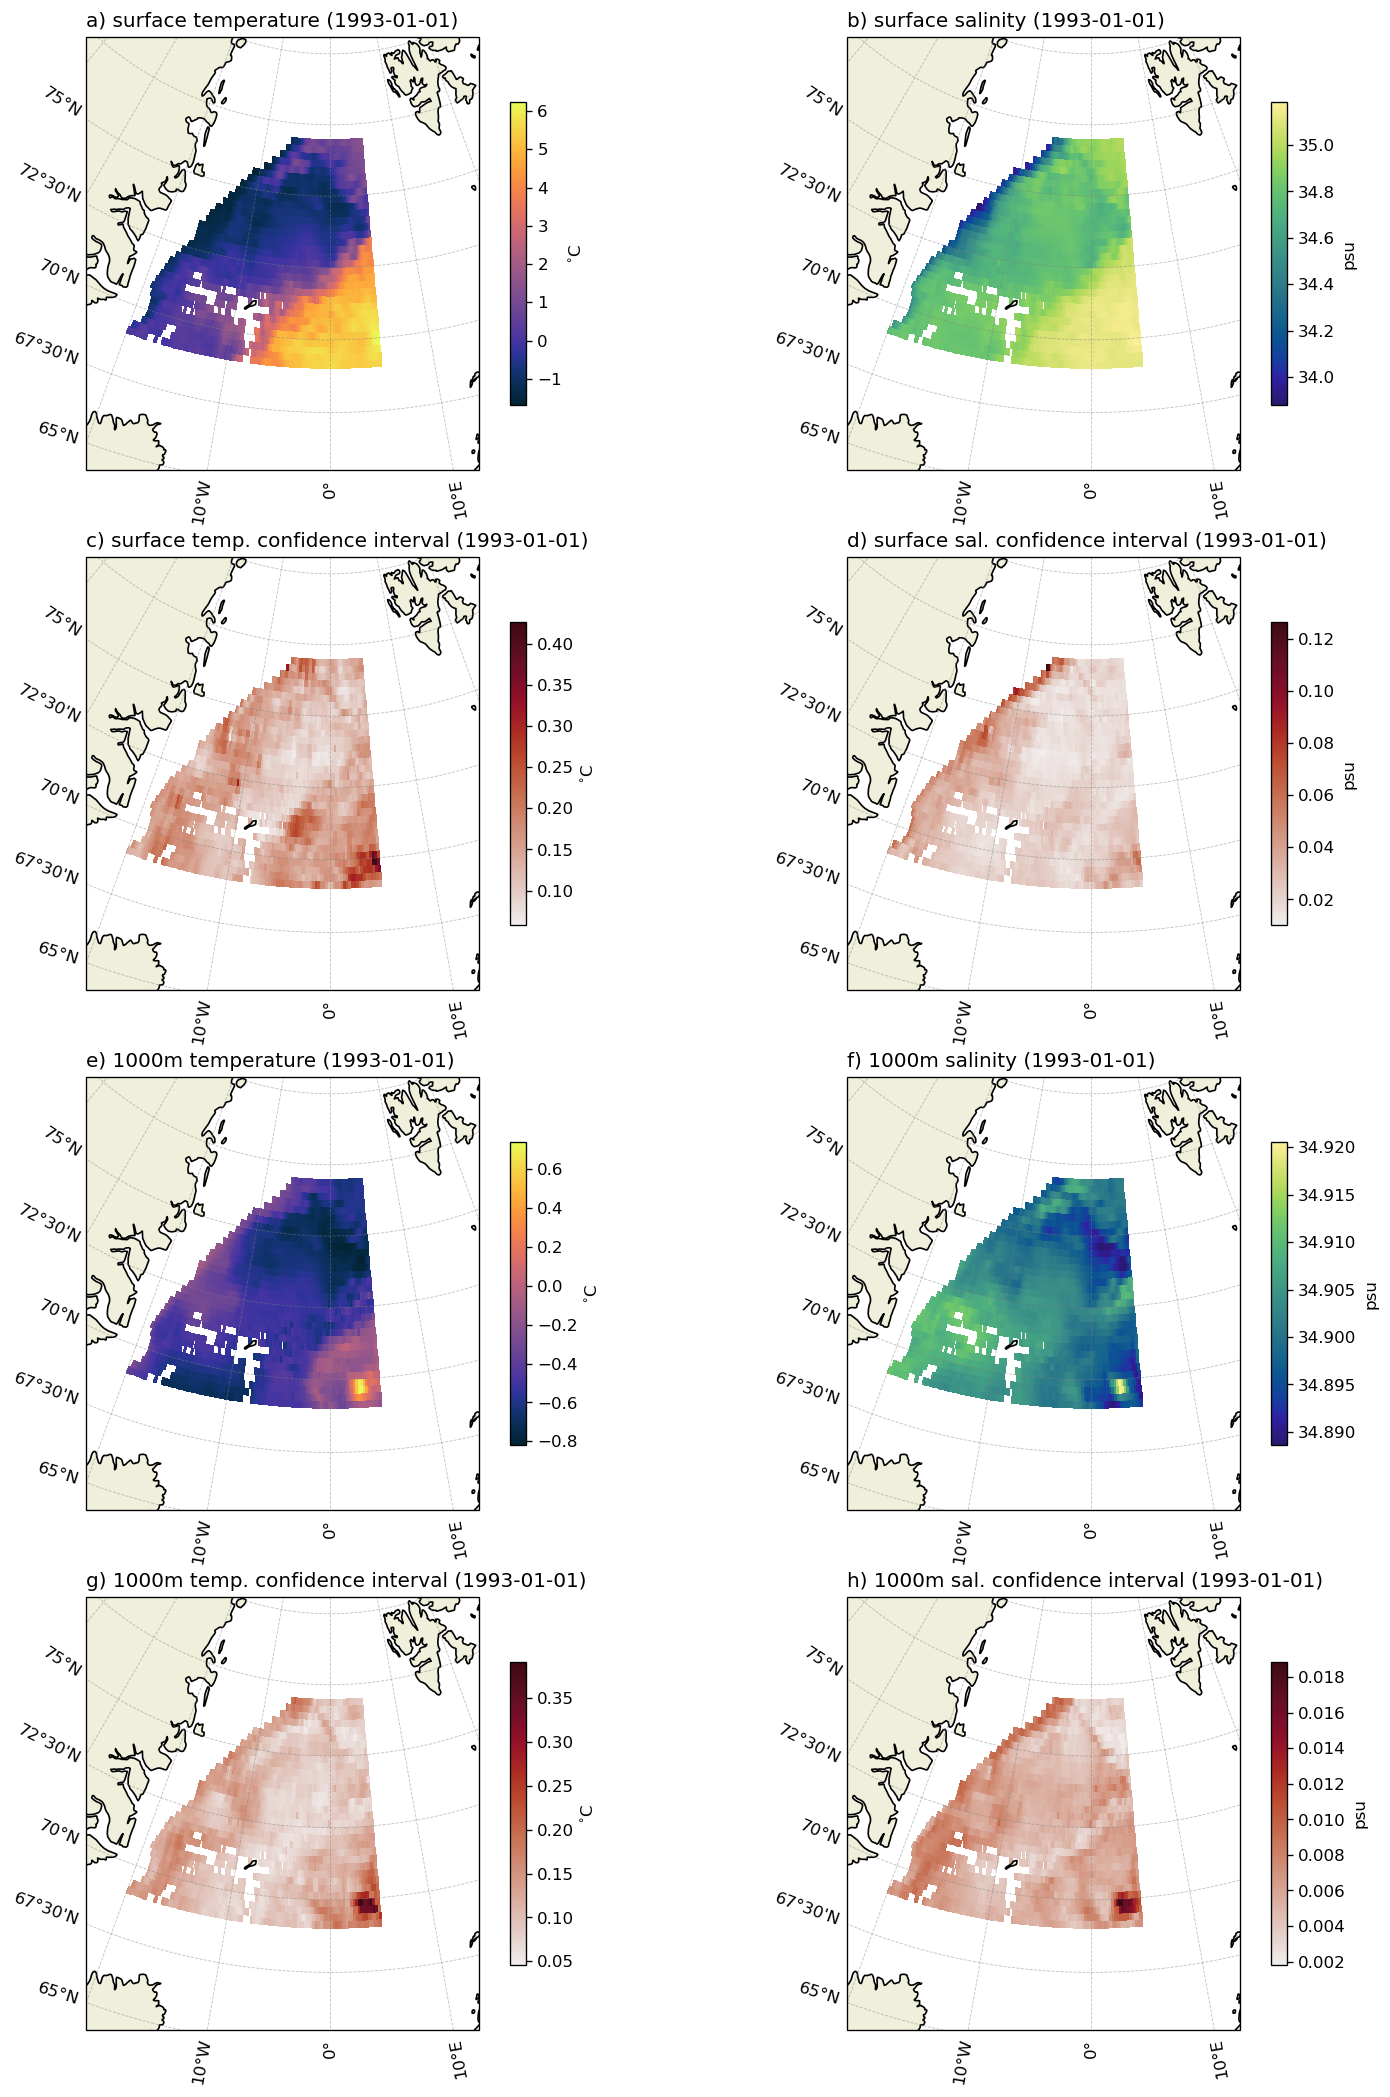

In [5]:
d = 0


subplot_kw = {'projection': proj, 'extent': extent}

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 22), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

for i in [0,2]:
    if i==0:
        d = 0
        ax[i+0,0].set_title('a) surface temperature (' + t + ')',loc = 'left')
        ax[i+0,1].set_title('b) surface salinity (' + t + ')',loc = 'left')
        ax[i+1,0].set_title('c) surface temp. confidence interval (' + t + ')',loc = 'left')
        ax[i+1,1].set_title('d) surface sal. confidence interval (' + t + ')',loc = 'left')
    if i==2:
        d = 1000
        ax[i+0,0].set_title('e) 1000m temperature (' + t + ')',loc = 'left')
        ax[i+0,1].set_title('f) 1000m salinity (' + t + ')',loc = 'left')
        ax[i+1,0].set_title('g) 1000m temp. confidence interval (' + t + ')',loc = 'left')
        ax[i+1,1].set_title('h) 1000m sal. confidence interval (' + t + ')',loc = 'left')
        
    cb = ds['TEMP_predicted'].sel(time = t,DEPTH =  d).plot(ax=ax[i+0,0],center = False,
                  cmap=cmocean.cm.thermal,
                  transform=ccrs.PlateCarree(),
                  cbar_kwargs={"shrink": 0.7,"label":'$^{\circ}$C'})


    ds['PSAL_predicted'].sel(time = t,DEPTH = d).plot(ax=ax[i+0,1],
                  cmap=cmocean.cm.haline,
                  transform=ccrs.PlateCarree(),
                  cbar_kwargs={"shrink": 0.7,"label":'psu'})  
    
    ds['TEMP_predicted_std'].sel(time = t,DEPTH = d).plot(ax=ax[i+1,0],
                  cmap=cmocean.cm.amp,
                  transform=ccrs.PlateCarree(),
                  cbar_kwargs={"shrink": 0.7,"label":'$^{\circ}$C'})
    
    ds['PSAL_predicted_std'].sel(time = t,DEPTH = d).plot(ax=ax[i+1,1],
                  cmap=cmocean.cm.amp,
                  transform=ccrs.PlateCarree(),
                  cbar_kwargs={"shrink": 0.7,"label":'psu'})
    
    
for i in np.arange(4):
    for j in np.arange(2):
        ds_bat['bathymetry'].plot.contour(**kw,ax = ax[i,j])
        ax[i,j].add_feature(land_feature, edgecolor='black')
        gl = ax[i,j].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linewidth=.5, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False

plt.savefig(pathfig + 'TSmap'+str(t)+'.png', transparent=False)
plt.show()

### Glorys12extract


In [12]:
ds_glorys = xr.open_dataset("/home/ref-ocean-reanalysis/global-reanalysis-phy-001-030-daily/1993/01/mercatorglorys12v1_gl12_mean_19930101_R19930106.nc")

ds_glorys = ds_glorys.assign_coords(lon180=(((ds_glorys.longitude + 180) % 360) - 180))  
ds_glorys['longitude'] = ds_glorys.lon180
    
ds_glorys_reduc = ds_glorys.where((ds_glorys['longitude']>=configuration['longitude1']) & (ds_glorys['longitude']<=configuration['longitude2']) & (ds_glorys['latitude']>=configuration['latitude2']) & 
    (ds_glorys['latitude']<=configuration['latitude1']), drop=True)

ds_glorys_reduc.to_netcdf("/home1/datahome/mlejeune/glorys/out_test_glorys.nc")

### Extarct fom prediction

In [14]:
#Select one point of data

n = 0

ds_time = ds.isel(time=n)
ds_time_lat = ds_time.isel(lat=n)
dss = ds_time_lat.isel(lon=n)

In [15]:
ds_glorys = xr.open_dataset("/home1/datahome/mlejeune/glorys/out_test_glorys.nc")
ds_glorys_selected = ds_glorys.sel(time=dss['time'].data, longitude=dss['lon'].data, latitude=dss['lat'].data, method='nearest')


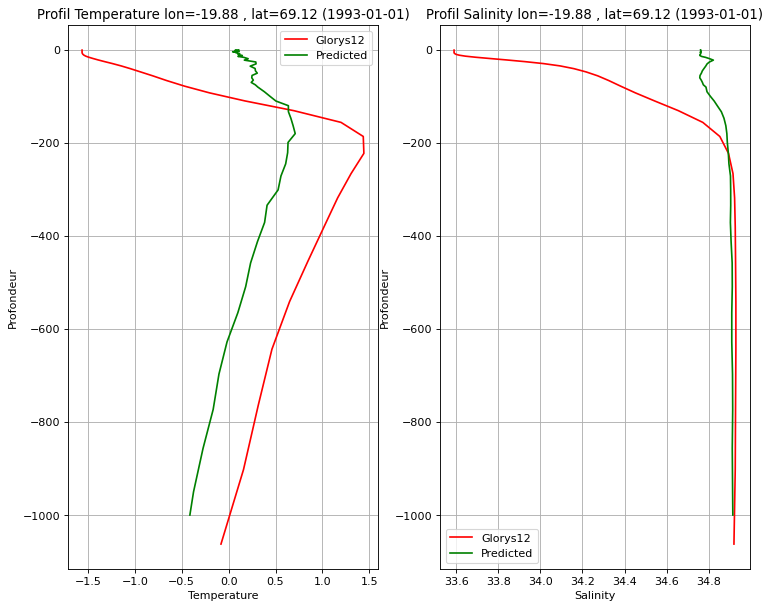

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(11,9), dpi=80, facecolor='w', edgecolor='k')

ds_glorys_clean = ds_glorys_selected.where(ds_glorys_selected.depth < 1100)


ax[0].plot(ds_glorys_clean['thetao'], -ds_glorys_clean['depth'], label='Glorys12',c = 'red')
ax[0].plot(dss['TEMP_predicted'], -dss['DEPTH'], label='Predicted',c = 'green')

ax[0].set_title('Profil Temperature lon=' + str(np.around(dss.lon.data, decimals=2)) + ' , lat=' + str(np.around(dss.lat.data, decimals=2)) + 
                ' (' + str(pd.to_datetime(dss.time.data).date()) + ')')

ax[1].set_title('Profil Salinity lon=' + str(np.around(dss.lon.data, decimals=2)) + ' , lat=' + str(np.around(dss.lat.data, decimals=2)) + 
                ' (' + str(pd.to_datetime(dss.time.data).date()) + ')')

ax[0].grid()

ax[1].plot(ds_glorys_clean['so'], -ds_glorys_clean['depth'], label='Glorys12',c = 'red')
ax[1].plot(dss['PSAL_predicted'], -dss['DEPTH'], label='Predicted',c = 'green')
ax[1].grid()


plt.setp(ax[0], xlabel='Temperature')
plt.setp(ax[1], xlabel='Salinity')

plt.setp(ax[0 : 2], ylabel='Profondeur')

leg = ax[0].legend();
leg = ax[1].legend();


In [14]:
ds

<xarray.Dataset>
Dimensions:             (time: 31, lat: 32, lon: 100, DEPTH: 51)
Coordinates:
    mask                (time, lat, lon) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
  * DEPTH               (DEPTH) int64 0 1 2 3 4 5 6 ... 628 697 773 857 950 1000
  * time                (time) datetime64[ns] 1993-01-01 ... 1993-01-31
  * lat                 (lat) float64 69.12 69.38 69.62 ... 76.38 76.62 76.88
  * lon                 (lon) float64 -19.88 -19.62 -19.38 ... 4.375 4.625 4.875
Data variables: (12/17)
    SLA                 (time, lat, lon) float32 -0.031 -0.0286 ... -0.0605
    UGOS                (time, lat, lon) float32 -0.0263 -0.0258 ... -0.0129
    VGOS                (time, lat, lon) float32 -0.0532 -0.0446 ... 0.072
    UGOSA               (time, lat, lon) float32 -0.0074 -0.0102 ... -0.0056
    VGOSA               (time, lat, lon) float32 0.0165 0.0184 ... 0.0491 0.0496
    SLA_err             (time, lat, lon) float32 0.0129 0.0127 ... 0.0176 0.0167
    ...                  ...
    PSAL_predicted      (DEPTH, time, lat, lon) float32 34.76 34.79 ... 34.9
    TEMP_predicted      (DEPTH, time, lat, lon) float32 0.04745 ... -0.5949
    PSAL_predicted_std  (DEPTH, time, lat, lon) float32 0.03623 ... 0.00411
    TEMP_predicted_std  (DEPTH, time, lat, lon) float32 0.1315 ... 0.09781
    MLD_mask            (DEPTH, time, lat, lon) float32 2.409e-07 ... 0.8051
    SIG_predicted       (DEPTH, time, lat, lon) float64 27.91 27.93 ... 28.06